In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pandas import Timestamp
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector


In [132]:
#Dataset: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

In this notebook Exploratory Data Analysis (EDA) was performed using the *London bike sharing dataset* from Kaggle with the goal of extracting useful information from the data in order to implement a Machine Learning model capable of predicting the number of bike rentals for specific days.

In [94]:
data_df = pd.read_csv("london_merged.csv")

#convert timestamp type to datetime
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

# Details of the data

In [95]:
data_df.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [96]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
timestamp       17414 non-null datetime64[ns]
cnt             17414 non-null int64
t1              17414 non-null float64
t2              17414 non-null float64
hum             17414 non-null float64
wind_speed      17414 non-null float64
weather_code    17414 non-null float64
is_holiday      17414 non-null float64
is_weekend      17414 non-null float64
season          17414 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [97]:
data_df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


## Feature Engineering

In [98]:

#add column representing the hour of the timestamp
data_df.loc[:, 'hour'] = data_df['timestamp'].dt.hour

#add column representing the month of the timestamp
data_df.loc[:, 'month'] = data_df['timestamp'].dt.month

#add column representing the day of the week
data_df['day_of_week'] = data_df['timestamp'].dt.dayofweek

#add column indicating if it is work day or not
data_df['work_day'] = [row['is_holiday'] == 0 and row['is_weekend'] == 0 for i, row in data_df.iterrows()]


In [99]:
data_df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,day_of_week
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.00000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075,11.513265,6.514643,2.99265
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911,6.915893,3.452509,2.00406
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000,6.000000,4.000000,1.00000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000,12.000000,7.000000,3.00000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000,18.000000,10.000000,5.00000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,23.000000,12.000000,6.00000


## Analysis of the **timestamp** column

In [100]:
time_diffs = np.diff(data_df['timestamp'])
time_diffs = time_diffs / np.timedelta64(1, 'h')

print("Unique values: ", np.unique(time_diffs))

Counter(time_diffs)

Unique values:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 16. 38.]


Counter({1.0: 17383,
         2.0: 16,
         3.0: 2,
         4.0: 2,
         5.0: 2,
         6.0: 1,
         7.0: 1,
         8.0: 1,
         9.0: 2,
         11.0: 1,
         16.0: 1,
         38.0: 1})

This way we can conclude that the time interval between each sample is 1 hour most of the time, although there are some exceptions

In [101]:
display(min(data_df['timestamp']))
display(max(data_df['timestamp']))

Timestamp('2015-01-04 00:00:00')

Timestamp('2017-01-03 23:00:00')

Data goes from 2015-01-04 to 2017-01-03

## Analysis of the **t1**  and **t2** columns

Variation of the temperature t1 and t2 in just the fist week: from **2015-01-04 00:00** to **2015-01-11 00:00**

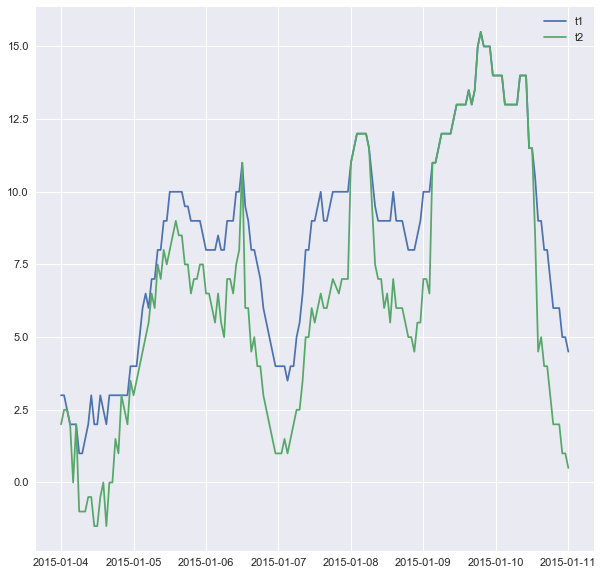

From: 2015-01-04 00:00:00
To: 2015-01-11 00:00:00


In [102]:
n_days = 7
plt.figure(figsize=(10,10))
plt.plot(data_df['timestamp'][:n_days * 24],data_df['t1'][:n_days * 24], label="t1")
plt.plot(data_df['timestamp'][:n_days * 24],data_df['t2'][:n_days * 24], label="t2")

plt.legend()
plt.show()

print('From: {}\nTo: {}'.format(data_df['timestamp'][0], data_df['timestamp'][n_days * 24 - 1]))

Variation of the temperature t1 and t2 for the entire data time interval: from **2015-01-04 00:00** to **2017-01-03 23:00**. Tipically the "feeling like" temperature is lower than the real one

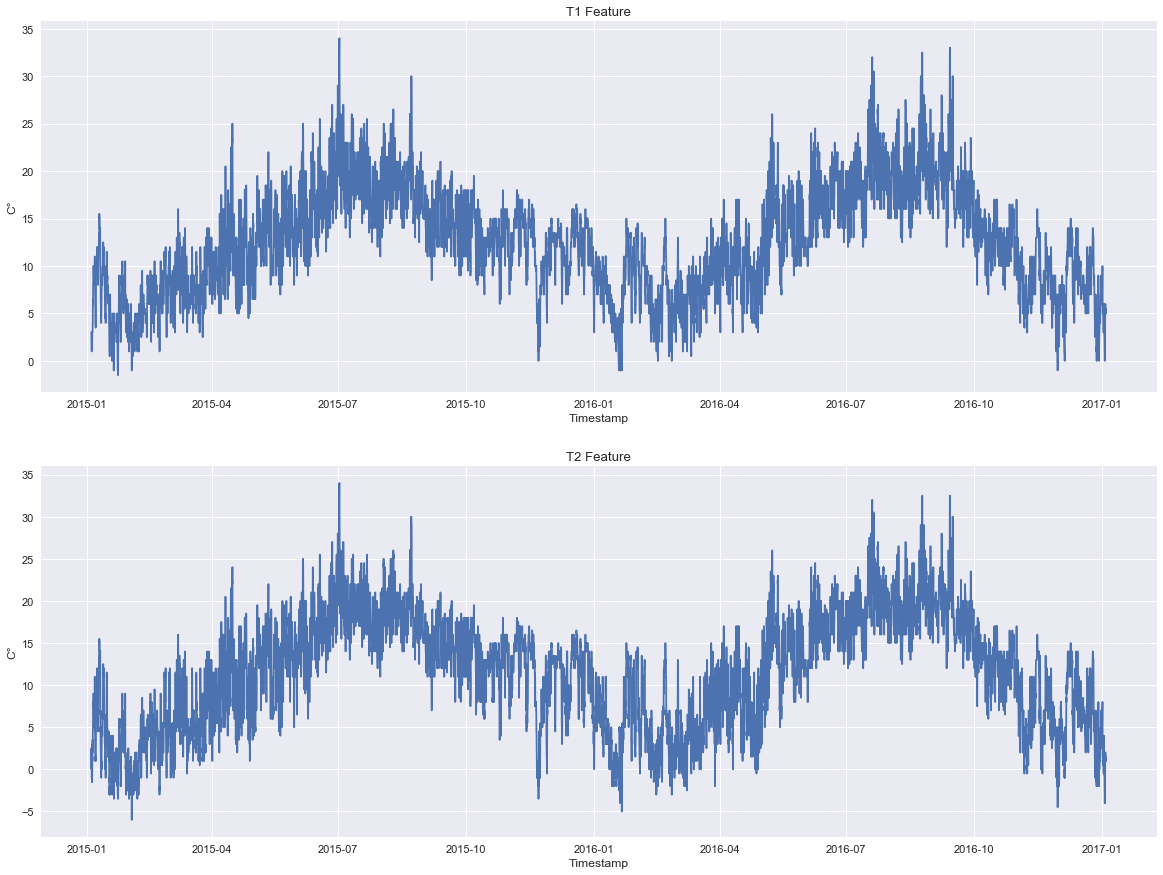

In [103]:

fig, ax = plt.subplots(2, 1, figsize=(20,15))

ax[0].plot(data_df['timestamp'],data_df['t1'], label="t1")
ax[1].plot(data_df['timestamp'],data_df['t2'], label="t2")

ax[0].title.set_text('T1 Feature')
ax[1].title.set_text('T2 Feature')

ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel(u'C°')

ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel(u'C°')

plt.show()

By analysing the entire data timestamp, it is possible to see some seasonality over time regarding the t1.

In [104]:
#Analysis of the correlation of the temperatue in each year

'Correlation between T1 and T2 over the years'

,t1,t2
t1,1.000000,0.988344
t2,0.988344,1.000000


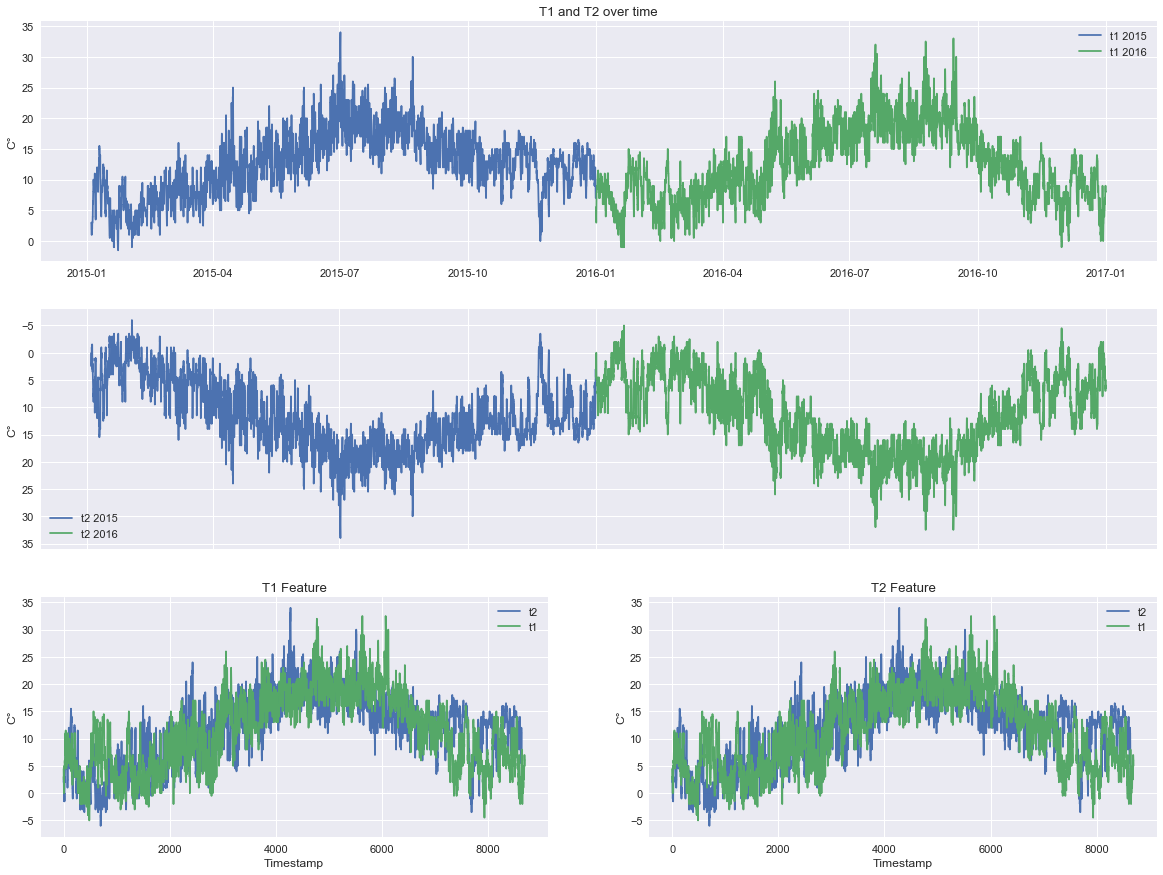

In [105]:
data_2015 = data_df.loc[(data_df['timestamp'] > Timestamp('2015-01-01 0:0:0')) & (data_df['timestamp'] <= Timestamp('2015-12-31 23:59:59'))]
data_2016 = data_df.loc[(data_df['timestamp'] > Timestamp('2016-01-01 0:0:0')) & (data_df['timestamp'] <= Timestamp('2016-12-31 23:59:59'))]


fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 2)


top_ax = fig.add_subplot(grid[0, 0:])
top_ax.plot(data_2015['timestamp'], data_2015['t1'], label="t1 2015")
top_ax.plot(data_2016['timestamp'], data_2016['t1'], label="t1 2016")
top_ax.set_ylabel(u'C°')

top_ax.legend()


mid_ax = fig.add_subplot(grid[1, 0:], sharex = top_ax)
plt.setp(mid_ax.get_xticklabels(), visible=False)
mid_ax.plot(data_2015['timestamp'], data_2015['t2'], label="t2 2015")
mid_ax.plot(data_2016['timestamp'], data_2016['t2'], label="t2 2016")
mid_ax.invert_yaxis()
mid_ax.set_ylabel(u'C°')

mid_ax.legend()

left_ax = plt.subplot(grid[2, 0]);
left_ax.plot([i for i in range(0, len(data_2015))], data_2015['t2'], label="t2")
left_ax.plot([i for i in range(0, len(data_2016))], data_2016['t2'], label="t1")

right_ax = plt.subplot(grid[2, 1]);
right_ax.plot([i for i in range(0, len(data_2015))], data_2015['t2'], label="t2")
right_ax.plot([i for i in range(0, len(data_2016))], data_2016['t2'], label="t1")

top_ax.title.set_text('T1 and T2 over time')
left_ax.title.set_text('T1 Feature')
right_ax.title.set_text('T2 Feature')

left_ax.set_xlabel('Timestamp')
left_ax.set_ylabel(u'C°')
left_ax.legend()

right_ax.set_xlabel('Timestamp')
right_ax.set_ylabel(u'C°')
right_ax.legend()



display('Correlation between T1 and T2 over the years', data_df[['t1', 't2']].corr())

plt.show()

As can be observed, the T1 and T2 features are highly correlated. Furthermore, the temperature evolution over the year follows a specific pattern, as it is identical in 2015 and 2016

## Analysis of the influence of *weather code*

In [106]:
print(data_df['weather_code'].unique())

data_df.loc[data_df['weather_code'] == 26, 'weather_code'] = 5
data_df.loc[data_df['weather_code'] == 10, 'weather_code'] = 6
data_df.loc[data_df['weather_code'] == 94, 'weather_code'] = 8


[ 3.  1.  4.  7.  2. 26. 10.]


By changing these specific codes, the new weather codes are ordered sequentially in time

## Analysis of the influence of Weather in the number of bikes shares: *t1, t2, hum, wind_speed, weather_code, season*

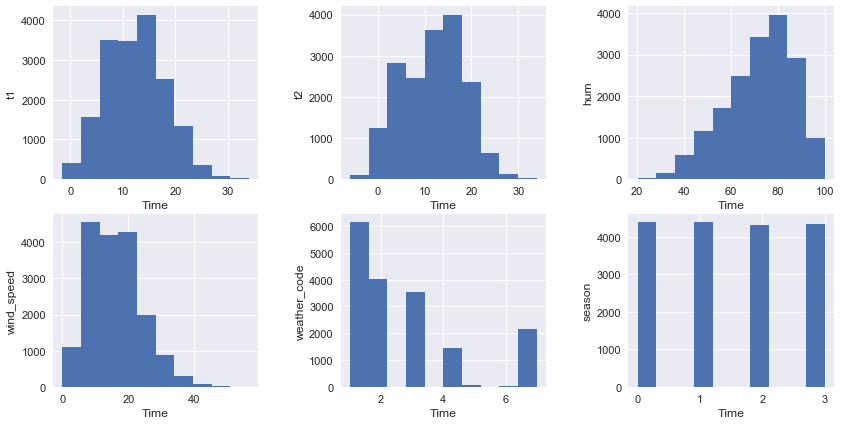

In [107]:

def plot_sensors_hist(df, s_columns):

    fig = plt.figure(figsize=(14, 7))
    fig.subplots_adjust(wspace=0.4)

    
    for i, s in enumerate(s_columns):

        ax = plt.subplot(2, 3, i+1)
        
        vals = df[s]

        vals.hist()
        
        ax.set_ylabel(s)
        ax.set_xlabel('Time')

    plt.show()

        
plot_sensors_hist(data_df, ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'season'])




From the plots, the histogram of *t1, t2, hum and wind_speed* are within the expected. However, *weather_code* and *season* feature show strange values distribution. These assymetrical distributions are due the fact that the values follow a specific coding system, namelly:

**weather_code** (updated codes):
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
2 = scattered clouds / few clouds
3 = Broken clouds
4 = Cloudy
5 = snowfall
6 = rain with thunderstorm
7 = Rain/ light Rain shower/ Light rain
8 = Freezing Fog

**season**:
0-spring ; 1-summer; 2-fall; 3-winter.

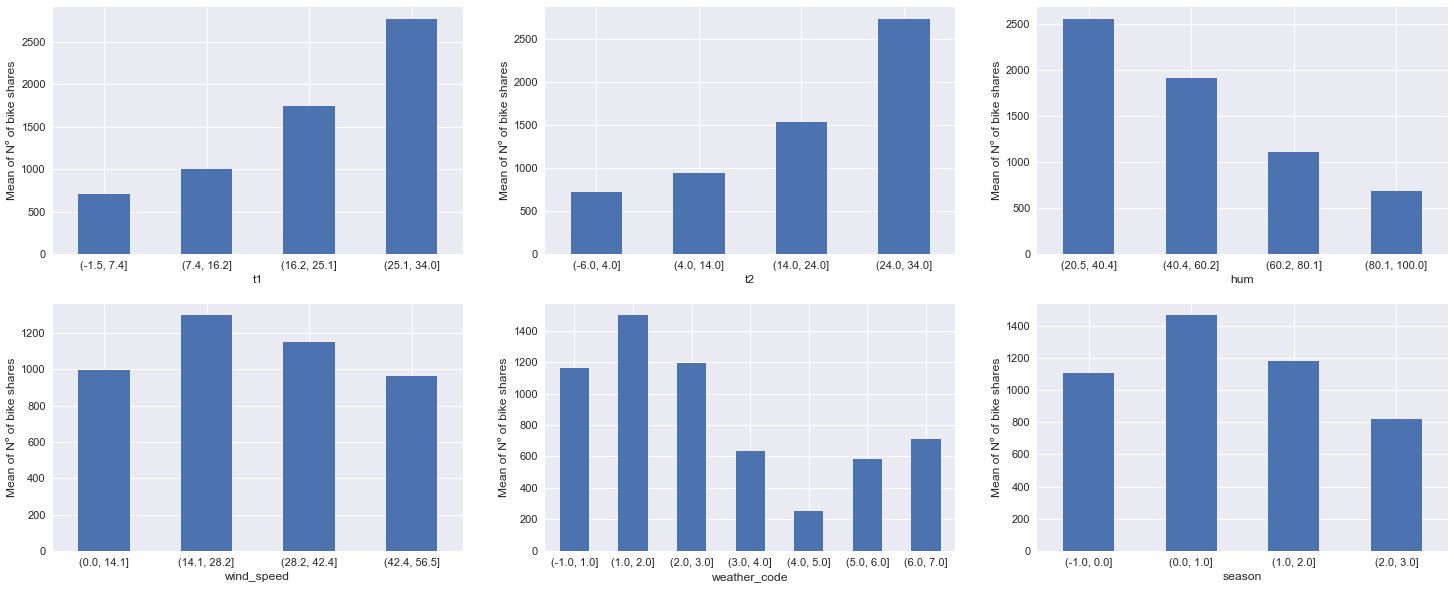

In [108]:


def plot_bar_cnt(df, s_columns, custom_bins):
    
    fig = plt.figure(figsize=(25, 10))
    fig.subplots_adjust(wspace=0.2)

    t_df = df.copy()
    for i, s in enumerate(s_columns):

        ax = plt.subplot(2, 3, i+1)

        custom_bins[i] = np.round(custom_bins[i], 1)
        
        t_df['bins'] = pd.cut(x=t_df[s], bins=custom_bins[i])
        
        t_df.groupby('bins').mean()['cnt'].plot.bar(rot=0)
        
        ax.set_ylabel('Mean of Nº of bike shares')
        ax.set_xlabel(s)

    plt.show()

        
custom_bins = [np.linspace(min(data_df['t1']), max(data_df['t1']), num=5),
        np.linspace(min(data_df['t2']), max(data_df['t2']), num=5),
        np.linspace(min(data_df['hum']), max(data_df['hum']), num=5),
        np.linspace(min(data_df['wind_speed']), max(data_df['wind_speed']), num=5),
        np.append(-1, np.linspace(min(data_df['weather_code']), max(data_df['weather_code']), num=len(data_df['weather_code'].unique()))),
        np.append(-1, np.linspace(min(data_df['season']), max(data_df['season']), num=len(data_df['season'].unique()))),
       ]

plot_bar_cnt(data_df, ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'season'], custom_bins)


Some conclusions can be drawn from these plots. Regarding the temperature (t1 and t2), the probability of people riding a rented bike is higher as the temperature increases. The opposite happens with the humidity, this means that people are more likely to rent a bike when the humidity is lower. By observing the wind speed, we can conclude that it does not have a significal impact on the number of bike rides, as the number of bike shares is regular even at different wind speeds. Finally, by analysing the weather_code and the season, we can conclude that the bike rentals are higher when there are fewer clouds (weather_code = 2) in the summer (season = 1)

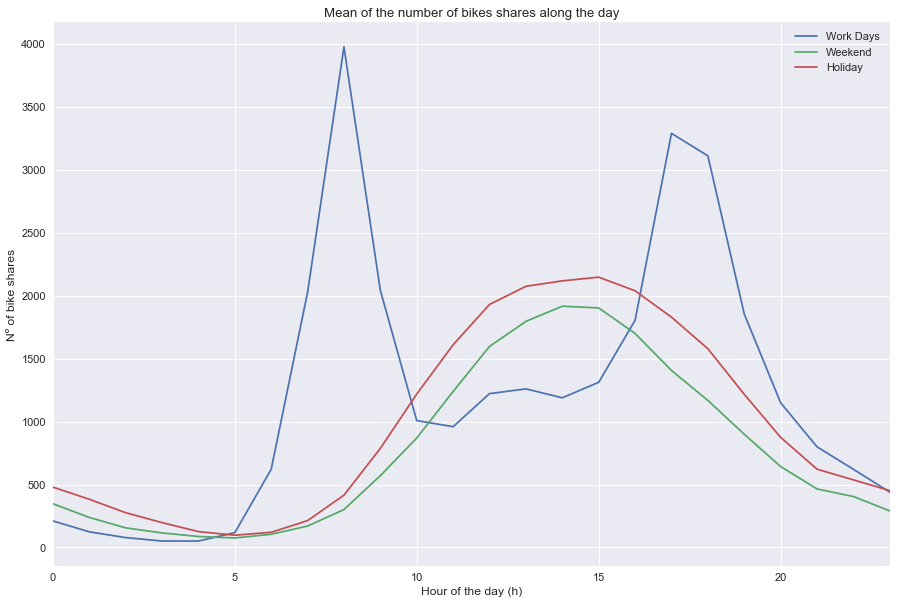

In [109]:

def plot_hourly_cnt(df, label):
    df.groupby(df['hour']).mean()['cnt'].plot(label=label)
    
    
    
fig, ax = plt.subplots(figsize=(15,10))

plot_hourly_cnt(data_df.loc[(data_df['is_holiday'] == 0) & (data_df['is_weekend'] == 0), :], 'Work Days')
plot_hourly_cnt(data_df.loc[data_df['is_holiday'] == 1, :], 'Weekend')
plot_hourly_cnt(data_df.loc[data_df['is_weekend'] == 1, :], 'Holiday')

ax.set_ylabel('Nº of bike shares')
ax.title.set_text('Mean of the number of bikes shares along the day')
ax.set_xlabel('Hour of the day (h)')

plt.legend()
plt.show()


In this graph, we can see that during work days, people tend to ride the rental bikes more during the morning (possibly on their way to work) and in the late afternoon (when leaving their work). During the weekends and holidays, the bike sharing trend is different, as people tend to ride more between the 10am and about 5pm. 

## Analysis of the number of bike sharing, depending the type of the day (work day, weekend, holiday)

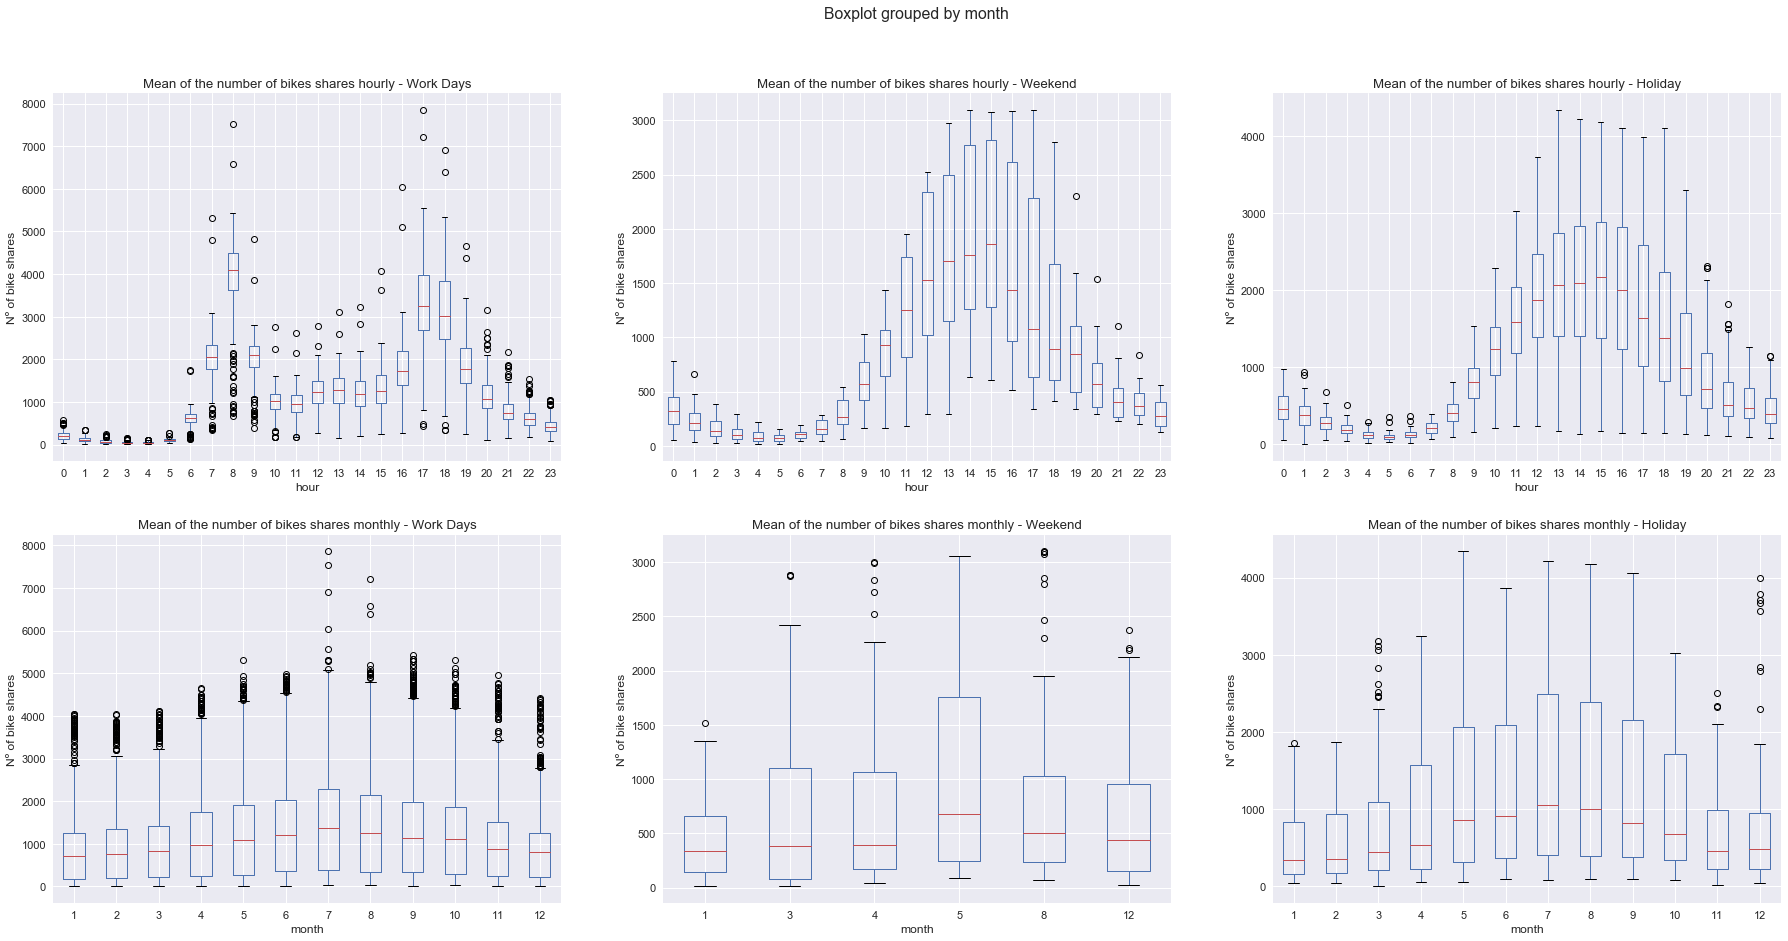

In [110]:
def plot_cnt(df, label, ax):
    #df.groupby(df['timestamp'].dt.month).mean()['cnt'].plot.bar(label=label, rot=0)

    df.boxplot(column='cnt', by='hour', ax=ax[0])
    df.boxplot(column='cnt', by='month', ax=ax[1])
    ax[0].title.set_text('Mean of the number of bikes shares hourly - ' + label)
    ax[1].title.set_text('Mean of the number of bikes shares monthly - ' + label)
    ax[0].set_ylabel('Nº of bike shares')
    ax[1].set_ylabel('Nº of bike shares')
    
    

fig, ax = plt.subplots(2, 3, figsize=(30, 15))

plot_cnt(data_df.loc[(data_df['is_holiday'] == 0) & (data_df['is_weekend'] == 0), :], 'Work Days', ax[:, 0])
plot_cnt(data_df.loc[data_df['is_holiday'] == 1, :], 'Weekend', ax[:, 1])
plot_cnt(data_df.loc[data_df['is_weekend'] == 1, :], 'Holiday', ax[:, 2])

plt.show()

As can be observed, the conclusions made previously regarding the number of bike rentals for each type of day (work day, weekend and holiday) are verified by these graphs.
Regarding the number of bike shares in each month, we can conclude that during the summer people rent more bikes, probably due to the favourable weather.

## Analysis of the **correlation** between the different variables with respect to column **cnt**.

In [111]:
#Plot the data features, in groups of 2

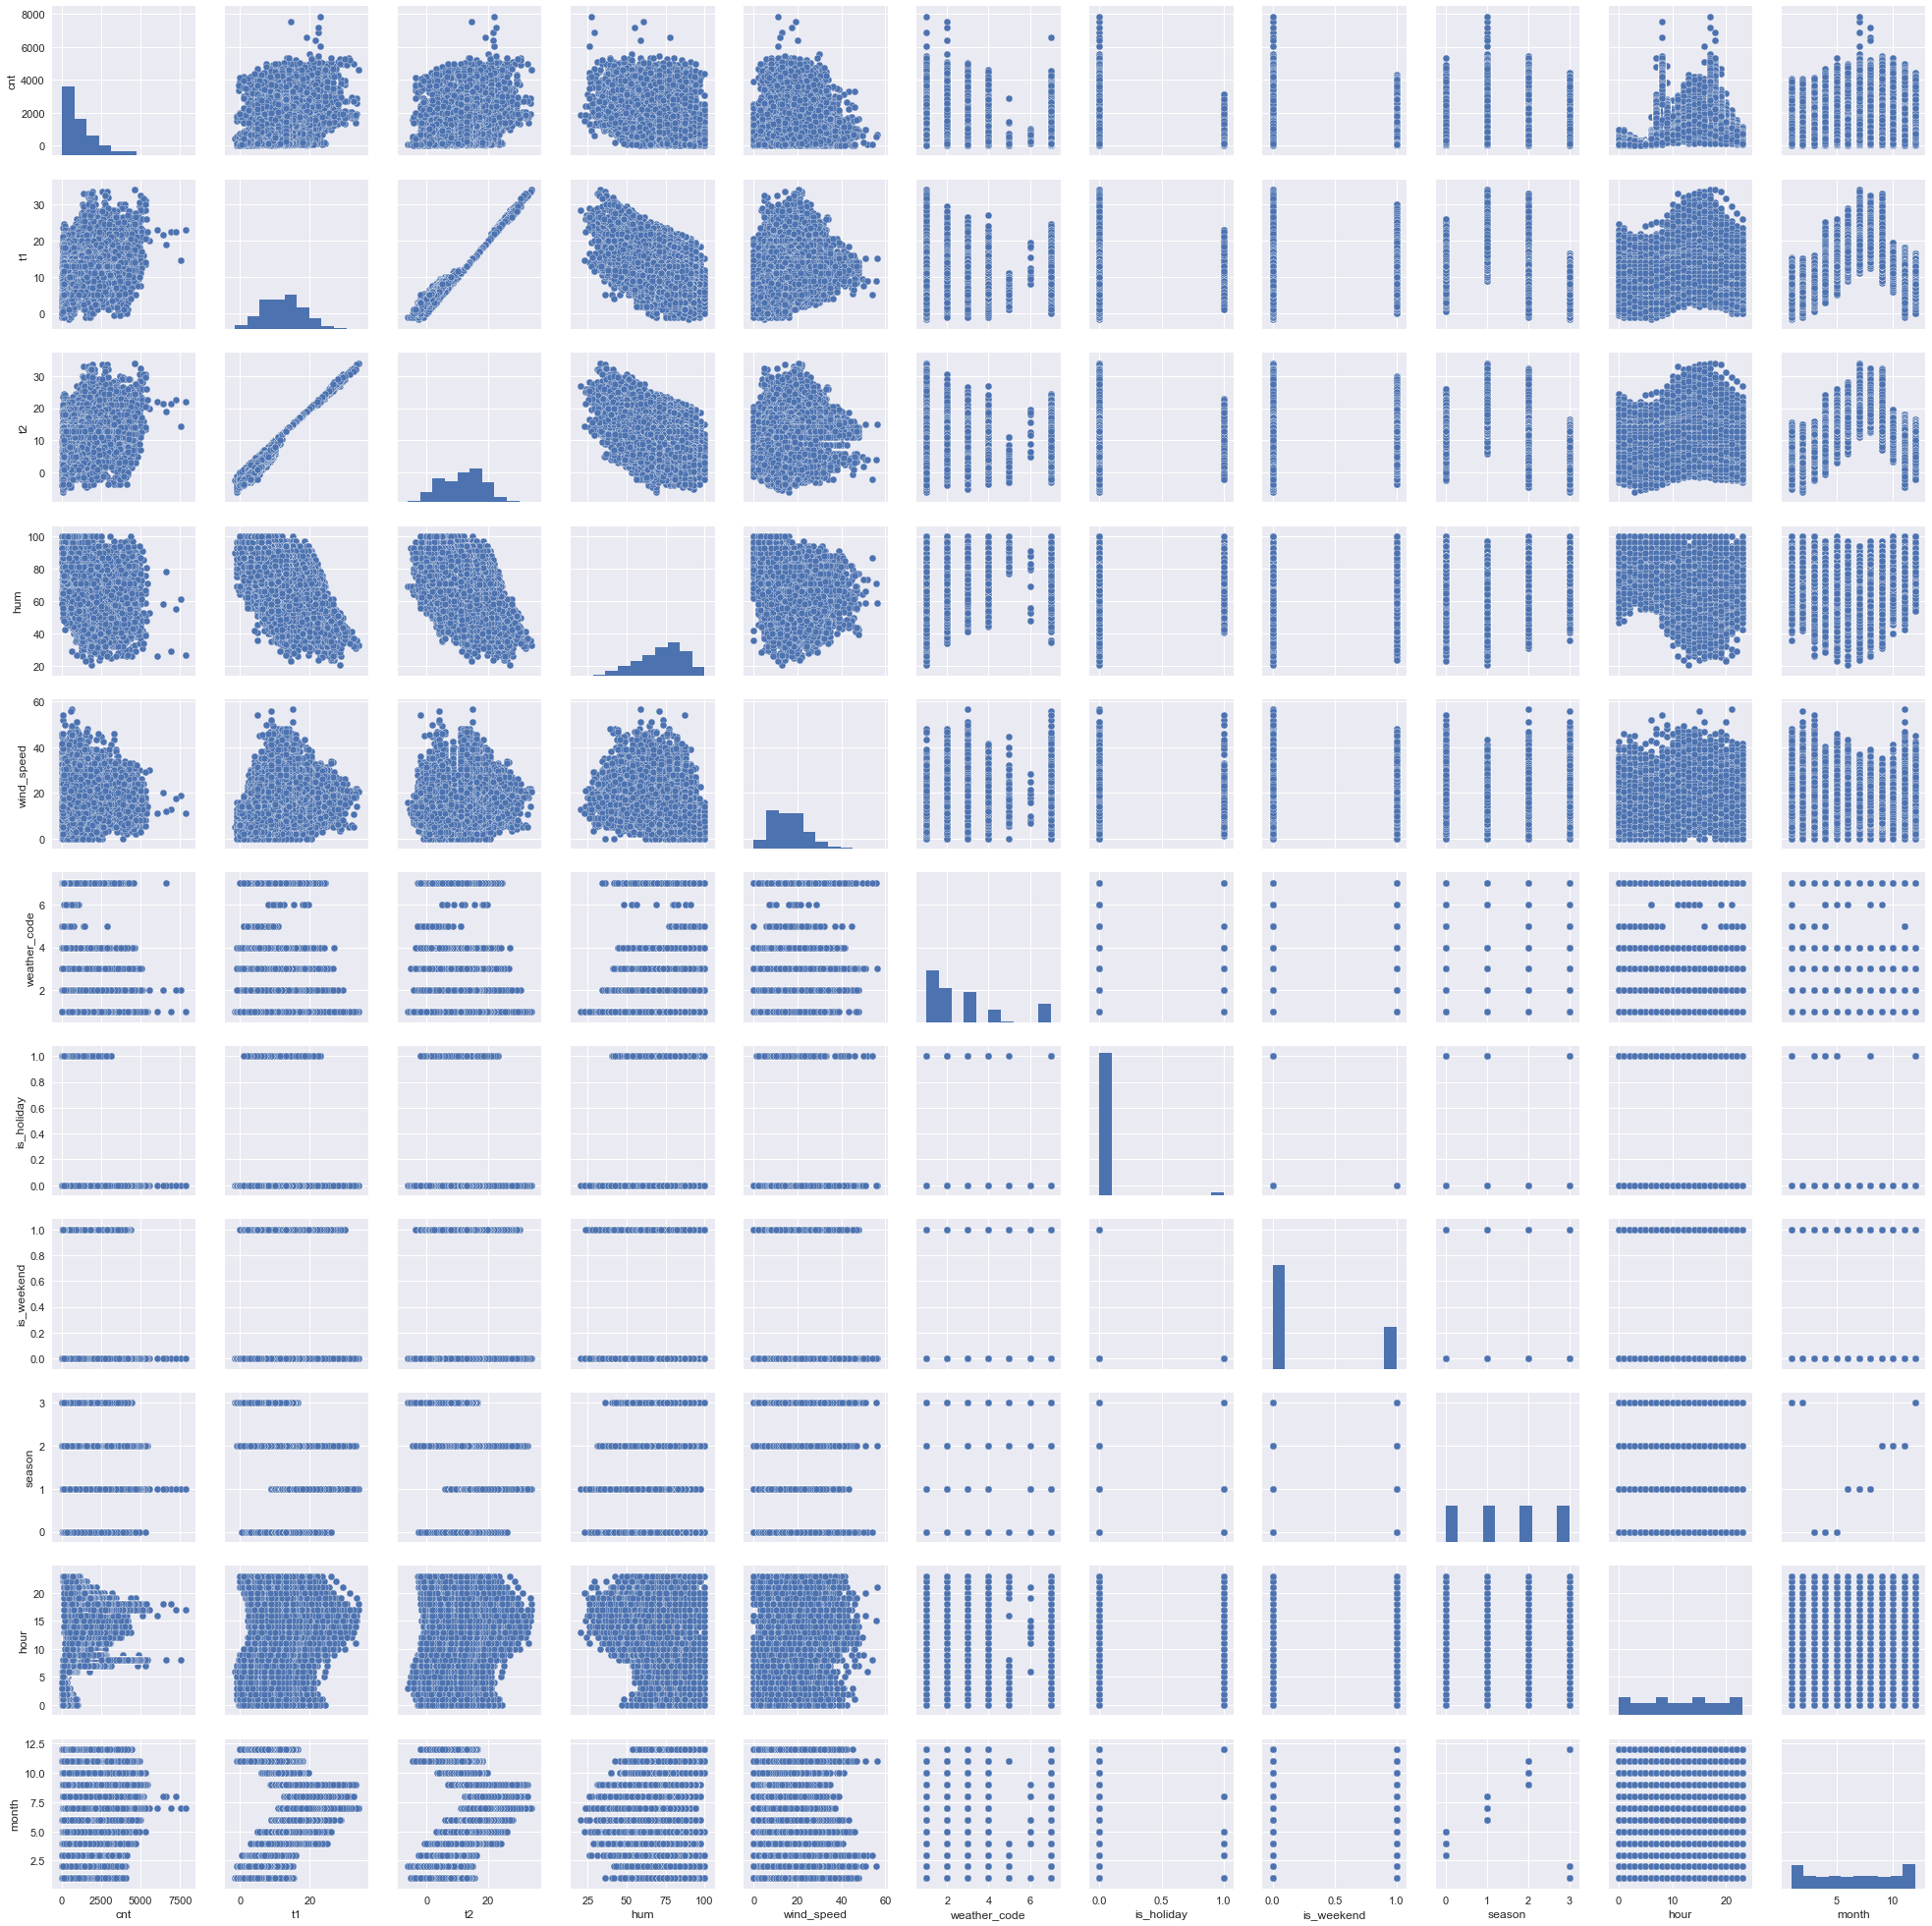

In [112]:
sns.pairplot(data_df[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season', 'hour', 'month']])
plt.show()

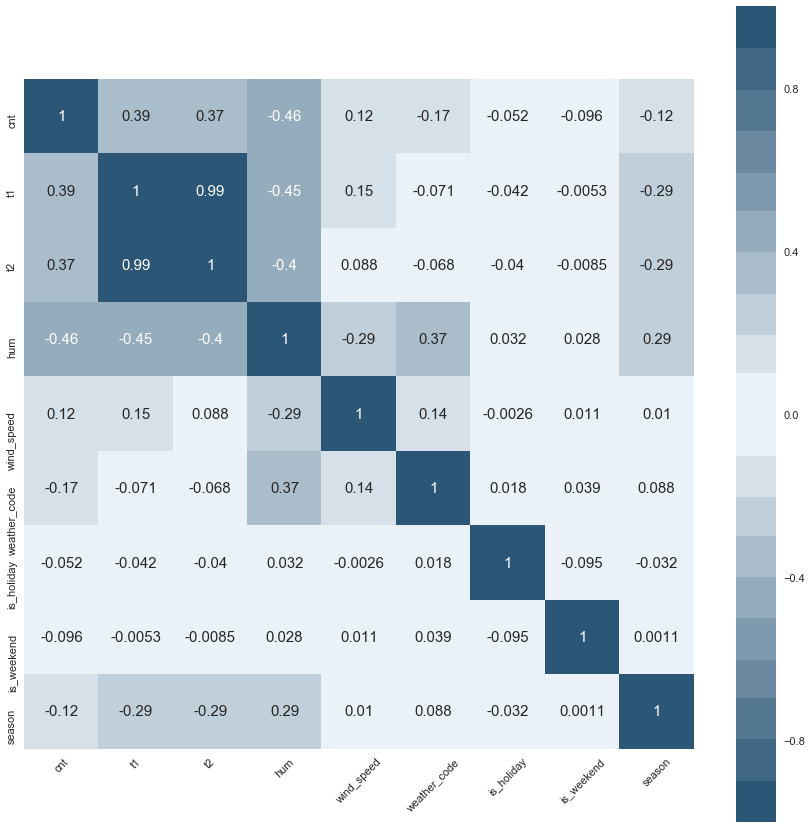

In [113]:

data_df[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']].corr()['cnt']


plt.figure(figsize=(15,15))

sns.set(font_scale=1.1)

ax = sns.heatmap(
    data_df[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 240, l=35, n=20),
    square=True,
    annot=True, annot_kws={"size": 15}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);

           
plt.show()


As can be concluded, there are no variables highly correlated with the **cnt column**.

Furthermore, the variables with higher correlation are the **humidity** (negative correlation) and the **temperature** (t1 and t2)



## Prediction of number of bike shares

The goal is to create a Machine Learning model capable of predicting the number of bikes needed in a certain day

#### Detection of Missing values

In [114]:
data_df.isnull().sum().sum()

0

#### Split in Train and Test dataset

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data_df[data_df.columns.difference(['timestamp', 'cnt'])], data_df['cnt'], test_size = 0.2, random_state = 0)
y_true = data_df['cnt']

#### Feature Selection

In [116]:
data_df.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season', 'hour', 'month', 'day_of_week',
       'work_day'],
      dtype='object')

Filter Methods - univariate selection

In [117]:
#1. K best
#Regression: f_regression, mutual_info_regression, chi2 (only positive number)

selector = SelectKBest(f_regression, k=4)
selector = SelectKBest(mutual_info_regression, k=4)
X_train_new = selector.fit_transform(X_train, y_train)

relevant_features_f1 = X_train.columns[selector.get_support(indices=True)].values
print("Feature Selected: ", X_train.columns[selector.get_support(indices=True)].values)


Feature Selected:  ['hour' 'hum' 't1' 't2']


In [118]:
#2. Variance Threshold

#Features with a training-set variance lower than this threshold will be removed. O means removing only constant features

thresholder = VarianceThreshold(threshold=15)
X_train_new_2 = thresholder.fit_transform(X_train)

relevant_features_f2 = X_train.columns[selector.get_support(indices=True)].values
print("Feature Selected: ", X_train.columns[thresholder.get_support(indices=True)].values)


Feature Selected:  ['hour' 'hum' 't1' 't2' 'wind_speed']


In [120]:
#3. Correlation

entire_X_train = X_train.copy()
entire_X_train['cnt'] = y_train

cor = entire_X_train[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']].corr()
cor_target = abs(cor["cnt"])

relevant_features_f3 = cor_target[cor_target>0.3]
print("Feature Selected: ", relevant_features_f3.index.values)

Feature Selected:  ['cnt' 't1' 't2' 'hum']


Wrapper Methods

In [121]:
#1. Forward: Adding feature with better results, in each iteration. The Random Forest model will be used

feature_selector = SequentialFeatureSelector(LinearRegression(),
           k_features=4,
           forward=True,
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=3)

mdl = feature_selector.fit(X_train, y_train)

relevant_features_w1 = X_train.columns[list(mdl.k_feature_idx_)]
print("Feature Selected: ", relevant_features_w1.values)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
Features: 4/4

Feature Selected:  ['hour' 'hum' 't1' 'work_day']


In [122]:
#2. Backward: Removing the feature with worse results, in each iteration. The Random Forest model will be used

feature_selector = SequentialFeatureSelector(LinearRegression(n_jobs=-1),
           k_features=5,
           forward=False,
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=3)

mdl = feature_selector.fit(X_train, y_train)

relevant_features_w2 = X_train.columns[list(mdl.k_feature_idx_)]
print("Feature Selected: ", relevant_features_w2.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished
Features: 11/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished
Features: 10/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
Features: 9/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
Features: 8/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished
Features: 7/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 6/5[Parallel(n_jo

Feature Selected:  ['hour' 'hum' 'is_weekend' 'season' 't1']


In [123]:
#3. RFE:

model = LinearRegression()
rfe = RFE(model, 5)
X_rfe = rfe.fit_transform(X_train, y_train)  

model.fit(X_rfe,y_train)

relevant_features_w3 = X_train.columns[rfe.support_]
#print(rfe.ranking_)
print("Feature Selected: ", relevant_features_w3.values)


Feature Selected:  ['is_holiday' 'is_weekend' 't1' 'weather_code' 'work_day']


Embedded Methods

In [124]:
#1. Lasso

#1.1 With cross validation to determine the best alpha

reg = LassoCV(cv = 3)
reg.fit(X_train, y_train)

coef = pd.Series(reg.coef_, index = X_train.columns)
relevant_features_l1 = [i for i in coef.index if coef[i] == 0.0]

print("Feature Selected: ", [i for i in coef.index if coef[i] == 0.0])



#1.2.1 Simple Lasso (without cv)

reg = Lasso(alpha = 7)
reg.fit(X_train, y_train)

coef = pd.Series(reg.coef_, index = X_train.columns)
relevant_features_l1

print("Feature Selected: ", [i for i in coef.index if coef[i] == 0.0])



#1.2.2 Lasso with Gradient Descent: only for classification

#2. Tree based: RF or XGBoost do not work for Regression


Feature Selected:  ['is_holiday', 'is_weekend']
Feature Selected:  ['is_holiday', 'is_weekend']


In [126]:
X_train = X_train[relevant_features_w1]
X_test = X_test[relevant_features_w1]

Different types of feature selection models were implemented. The method chosen to be applied was the **Forward Selection**, where the Linear Regression was used for evaluating the different features set performance

#### Identification of Categorical Data

In [133]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13931 entries, 4493 to 2732
Data columns (total 4 columns):
hour        13931 non-null int64
hum         13931 non-null float64
t1          13931 non-null float64
work_day    13931 non-null bool
dtypes: bool(1), float64(2), int64(1)
memory usage: 448.9 KB


In [127]:
def convert_to_categorical(X_train, X_test, column_names, y_true):
    df = pd.concat([X_train, X_test], sort=False)
    
    for col in column_names:
        if col in X_train.columns:
            df[col] = df[col].astype('category')
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1, sort=False)
            df.drop([col], axis=1, inplace=True)
    
    return train_test_split(df, y_true, test_size = 0.2, random_state = 0)


#cat_columns = ['weather_code']
#X_train, X_test, y_train, y_test = convert_to_categorical(X_train, X_test, cat_columns, y_true)


The columns *hour*, *month*, *day_of_week*, although they are of type int or float and have a set of possible values, they should not be represented as categorical features, because there is some relation between the values, ex: 1h is closer to 3h than 8h.

#### Data Normalization

In [128]:
continuous_columns = ['t1', 'hum']

sc = StandardScaler()
X_train[continuous_columns] = sc.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = sc.transform(X_test[continuous_columns])

In [129]:
X_train.head(10)

,hour,hum,t1,work_day
4493,16,-3.291949,2.429917,True
14407,2,-0.436098,0.727873,True
7862,6,-0.018169,-0.257521,False
2627,19,-0.192306,-0.167939,True
1764,14,-0.436098,-0.615846,True
16730,12,1.026655,-0.705427,True
7875,19,1.096310,-0.078358,False
9190,19,0.678380,-0.705427,False
9233,14,0.504243,0.190386,True
1271,1,0.678380,-0.257521,True


#### Application of a ML model

In [130]:
#XGBOOST

parameters = {
    'max_depth': [1, 5],
    'n_estimators': [400, 800],
    'learning_rate': [0.01, 0.05]
}
#'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 800


#Cross Validation
grid_search = GridSearchCV(
    estimator=xgboost.XGBRegressor(objective ='reg:squarederror'),
    param_grid=parameters,
    n_jobs = 10,
    cv = 10
)


grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_





/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}


In [ ]:
#sgb = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate= 0.01, max_dept= 1, n_estimators= 800)
#best_model = sgb.fit(X_train, y_train)

In [131]:
#Results

results = best_model.predict(X_test)

print("MSE: ", mean_squared_error(y_test, results))
print("MAE: ", mean_absolute_error(y_test, results))


MSE:  84706.56692092655
MAE:  174.34943331626172



A simple XGBoost model was applied with cross validation for parameter tuning. In the end, the obtained results are interesting, although they can still be improved.

Possible improvments could be the applicatioin of other type of Machine Learning methods, also performing parameter tuning in the ML model, as well as in the chosen method for feature selection.
